# 2D Burger Example

In [1]:
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt
from itertools import product
import sys,time
import os
import pickle
sys.path.append("..") # Adds higher directory to python modules path.
from scipy.interpolate import interp2d, Rbf
import matplotlib
from WLaSDI import WLaSDI
from WLaSDI_wendy import WLaSDI_wendy

### Import simulation data, parameters, etc.

In [45]:
snapshot_file = './data/snapshot_git_9pts.p'
FOM_file = './data/FOM_a85_w95.p' 

# Given parameters
nx = 60
ny = 60
m = (ny-2)*(nx-2) # 3364
nt = 1500
tstop = 2
dt = tstop/nt
t = np.linspace(0,tstop,nt+1)

In [47]:
snapshot = pickle.load(open(snapshot_file, 'rb'))

snapshot_u = snapshot['u'].reshape(-1,nx*ny).astype('float32')
snapshot_v = snapshot['v'].reshape(-1,nx*ny).astype('float32')

def addNoise(x, noise_ratio):
    signal_power = np.sqrt(np.mean(x**2))
    sigma = noise_ratio*signal_power
    noise = np.random.normal(0, sigma, x.shape)
    xobs = x + noise
    return xobs

noise_level = 1.0
snapshot_u = addNoise(snapshot_u, noise_level).astype('float32')
snapshot_v = addNoise(snapshot_v, noise_level).astype('float32')

ndata = snapshot_u.shape[0]

nset = round(ndata/(nt+1))

# remove BC
multi_index_i,multi_index_j=np.meshgrid(np.arange(nx),np.arange(ny),indexing='xy')
full_multi_index=(multi_index_j.flatten(),multi_index_i.flatten())
free_multi_index=(multi_index_j[1:-1,1:-1].flatten(),multi_index_i[1:-1,1:-1].flatten())

dims=(ny,nx)
full_raveled_indicies=np.ravel_multi_index(full_multi_index,dims)
free_raveled_indicies=np.ravel_multi_index(free_multi_index,dims)

orig_data_u = snapshot_u[:,free_raveled_indicies]
orig_data_v = snapshot_v[:,free_raveled_indicies]

[xv,yv]=np.meshgrid(np.linspace(-3,3,nx),np.linspace(-3,3,ny),indexing='xy')
x=xv.flatten()
y=yv.flatten()

x_free=x[free_raveled_indicies]
y_free=y[free_raveled_indicies]


### Applying POD

In [48]:
u,s,vh = LA.svd(orig_data_u.T)
sv_mass = np.cumsum(s)
sv_count = 5# [i for i,ss in enumerate(sv_mass) if ss/sv_mass[-1]>.99][0]+1
# s[sv_count:] = 0
print(sv_count, sv_mass[:sv_count]/sv_mass[-1])
phi_u = u[:,:sv_count]


u,s,vh = LA.svd(orig_data_v.T)
sv_mass = np.cumsum(s)
sv_count = 5# [i for i,ss in enumerate(sv_mass) if ss/sv_mass[-1]>.99][0]+1
# s[sv_count:] = 0
print(sv_count, sv_mass[:sv_count]/sv_mass[-1])
phi_v = u[:,:sv_count]

5 [0.01609294 0.02215789 0.02554894 0.02773515 0.02931994]
5 [0.0160907  0.0221558  0.02554384 0.02772791 0.02930918]


##  Generate Latent-Space Trajectories from Training Data

In [49]:
latent_space_SS_u = []
latent_space_SS_v = []

for foo in range(nset):
    latent_space_u = np.matmul(phi_u.T, orig_data_u[foo*(nt+1):(foo+1)*(nt+1)].T).T
    latent_space_v = np.matmul(phi_v.T, orig_data_v[foo*(nt+1):(foo+1)*(nt+1)].T).T
    latent_space_SS_u.append(latent_space_u)
    latent_space_SS_v.append(latent_space_v)

amp_arr = [.7, .8, .9]
width_arr = [.9,1.0, 1.1]
P = list(product(amp_arr, width_arr))
P = np.array(P)

##  Applying WLaSDI

Dynamical System for U

Dynamical System for V


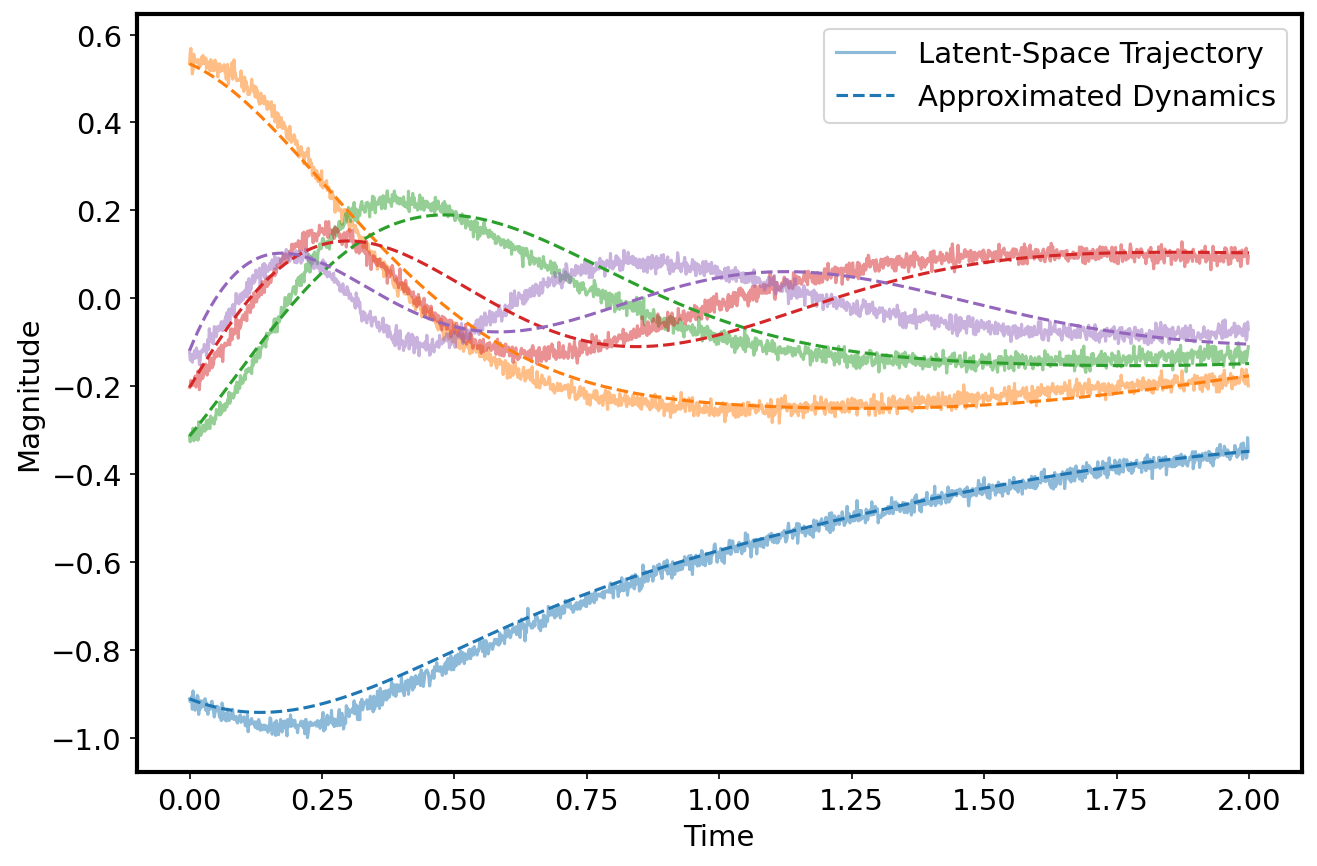

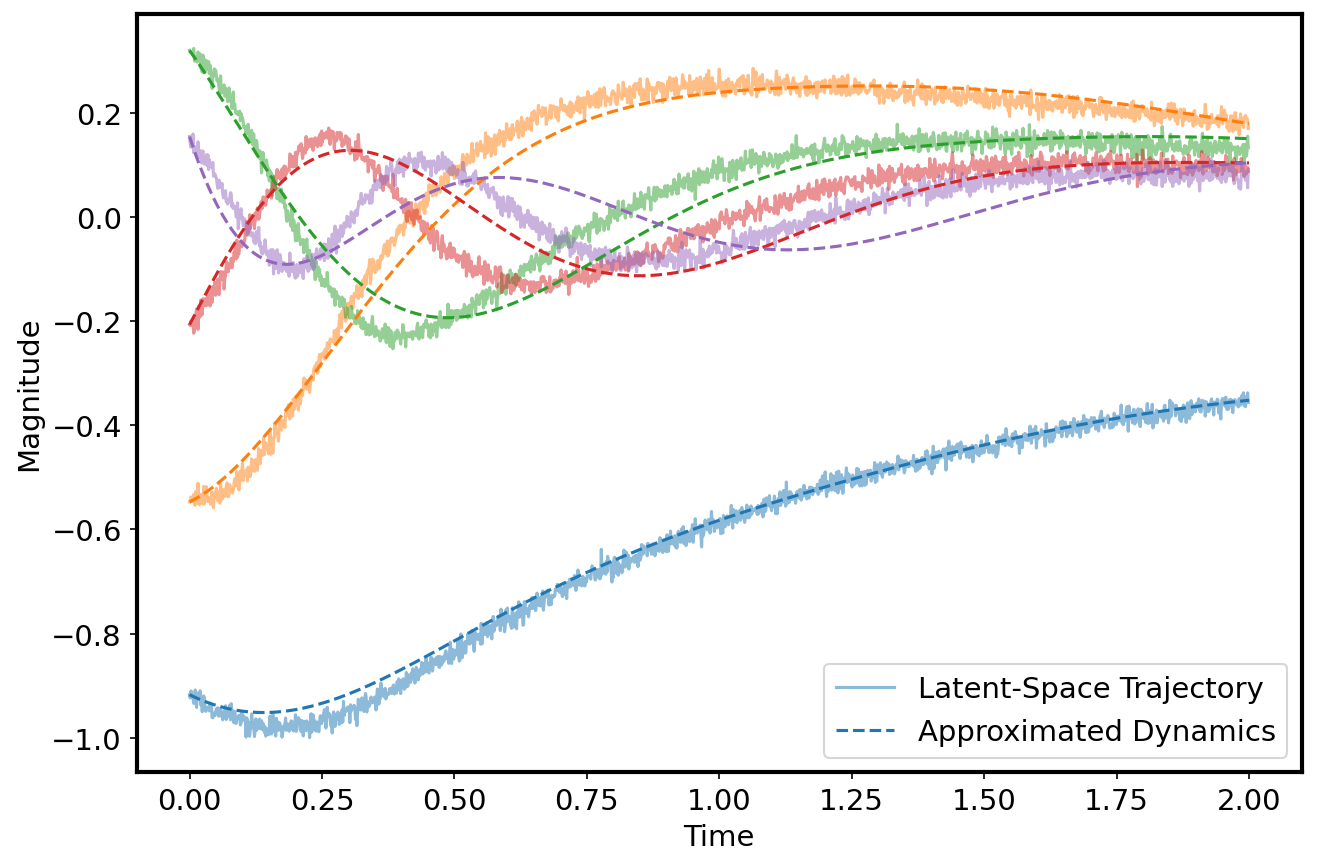

In [51]:
#Use WSINDy
print('Dynamical System for U')
normal_u = np.amax(np.abs(latent_space_SS_u))
#normal_u = 1
WLaSDI_model_u = WLaSDI(phi_u.T, phi_u, Local=False, Coef_interp=True, Coef_interp_method=Rbf, nearest_neigh = 7)
coef_u =  WLaSDI_model_u.train_dynamics(latent_space_SS_u, P, t, degree = 1, normal = normal_u,  gamma = 0.1, threshold=0, overlap=0.7, L = 30, LS_vis=True, useGLS = 1e-5)

print('\nDynamical System for V')
normal_v = np.amax(np.abs(latent_space_SS_v))
#normal_v = 1
WLaSDI_model_v = WLaSDI(phi_v.T, phi_v, Local=False, Coef_interp=True, Coef_interp_method=Rbf, nearest_neigh = 7)
coef_v = WLaSDI_model_v.train_dynamics(latent_space_SS_v, P, t, degree = 1, normal = normal_v,  gamma = 0.1, threshold=0, overlap=0.7, L = 30, LS_vis=True, useGLS = 1e-5)

In [22]:
#Use WENDy

features = [
        [lambda x0, x1, x2, x3, x4: x0*0 + 1, lambda x0, x1, x2, x3, x4: x0, lambda x0, x1, x2, x3, x4: x1, lambda x0, x1, x2, x3, x4: x2, lambda x0, x1, x2, x3, x4: x3, lambda x0, x1, x2, x3, x4: x4],
        [lambda x0, x1, x2, x3, x4: x0*0 + 1, lambda x0, x1, x2, x3, x4: x0, lambda x0, x1, x2, x3, x4: x1, lambda x0, x1, x2, x3, x4: x2, lambda x0, x1, x2, x3, x4: x3, lambda x0, x1, x2, x3, x4: x4],
        [lambda x0, x1, x2, x3, x4: x0*0 + 1, lambda x0, x1, x2, x3, x4: x0, lambda x0, x1, x2, x3, x4: x1, lambda x0, x1, x2, x3, x4: x2, lambda x0, x1, x2, x3, x4: x3, lambda x0, x1, x2, x3, x4: x4],
        [lambda x0, x1, x2, x3, x4: x0*0 + 1, lambda x0, x1, x2, x3, x4: x0, lambda x0, x1, x2, x3, x4: x1, lambda x0, x1, x2, x3, x4: x2, lambda x0, x1, x2, x3, x4: x3, lambda x0, x1, x2, x3, x4: x4],
        [lambda x0, x1, x2, x3, x4: x0*0 + 1, lambda x0, x1, x2, x3, x4: x0, lambda x0, x1, x2, x3, x4: x1, lambda x0, x1, x2, x3, x4: x2, lambda x0, x1, x2, x3, x4: x3, lambda x0, x1, x2, x3, x4: x4],
]

print('Dynamical System for U')
normal_u = np.amax(np.abs(latent_space_SS_u))
normal_u = 1
WLaSDI_model_u = WLaSDI_wendy(phi_u.T, phi_u, Local=True, Coef_interp=False, Coef_interp_method=Rbf, nearest_neigh = 7)
coef_u =  WLaSDI_model_u.train_dynamics(latent_space_SS_u, P, t,  features = features, normal = normal_u, gamma = 0.1, LS_vis = True, ls_meth = "LS", subsample=4, mt_params=[2**i for i in range(4)], toggle_VVp_svd = np.nan)

print('\nDynamical System for V')
normal_v = np.amax(np.abs(latent_space_SS_v))
normal_v = 1
WLaSDI_model_v = WLaSDI_wendy(phi_v.T, phi_v, Local=True, Coef_interp=False, Coef_interp_method=Rbf, nearest_neigh = 7)
coef_v = WLaSDI_model_v.train_dynamics(latent_space_SS_v, P, t,  features = features, normal = normal_v, gamma = 0.1, LS_vis = True, ls_meth = "LS", subsample=4, mt_params=[2**i for i in range(4)], toggle_VVp_svd = np.nan)

Dynamical System for U
Local approach WITHOUT SINDy coefficient interpolation

Dynamical System for V
Local approach WITHOUT SINDy coefficient interpolation


## ROM Generation

In [61]:
FOM_high_Re = pickle.load(open(FOM_file,'rb'))
u_full = FOM_high_Re['u']
v_full = FOM_high_Re['v']
time_FOM = FOM_high_Re['t']

u_full = u_full.reshape(-1, nx*ny)
v_full = v_full.reshape(-1,nx*ny)

start = time.time()
FOM_recon_u = WLaSDI_model_u.generate_ROM(u_full[0, free_raveled_indicies].astype('float32'), np.array([0.85,0.95]),t)
FOM_recon_v = WLaSDI_model_v.generate_ROM(v_full[0, free_raveled_indicies].astype('float32'), np.array([0.85,0.95]),t)
WLaSDI_time = time.time()-start

speed_up = time_FOM/WLaSDI_time
max_re = np.empty(2)
test_u = []
for k in range(int(nt+1)):
    test_u.append(LA.norm(FOM_recon_u[k].reshape(ny-2,nx-2)-u_full[k,free_raveled_indicies].reshape(ny-2,nx-2))/LA.norm(u_full[k,free_raveled_indicies].reshape(ny-2,nx-2))*100)
max_re[0] = np.amax(test_u)

test_v = []
for k in range(int(nt+1)):
    test_v.append(LA.norm(FOM_recon_v[k].reshape(ny-2,nx-2)-v_full[k,free_raveled_indicies].reshape(ny-2,nx-2))/LA.norm(v_full[k,free_raveled_indicies].reshape(ny-2,nx-2))*100)
max_re[1] = np.amax(test_v)

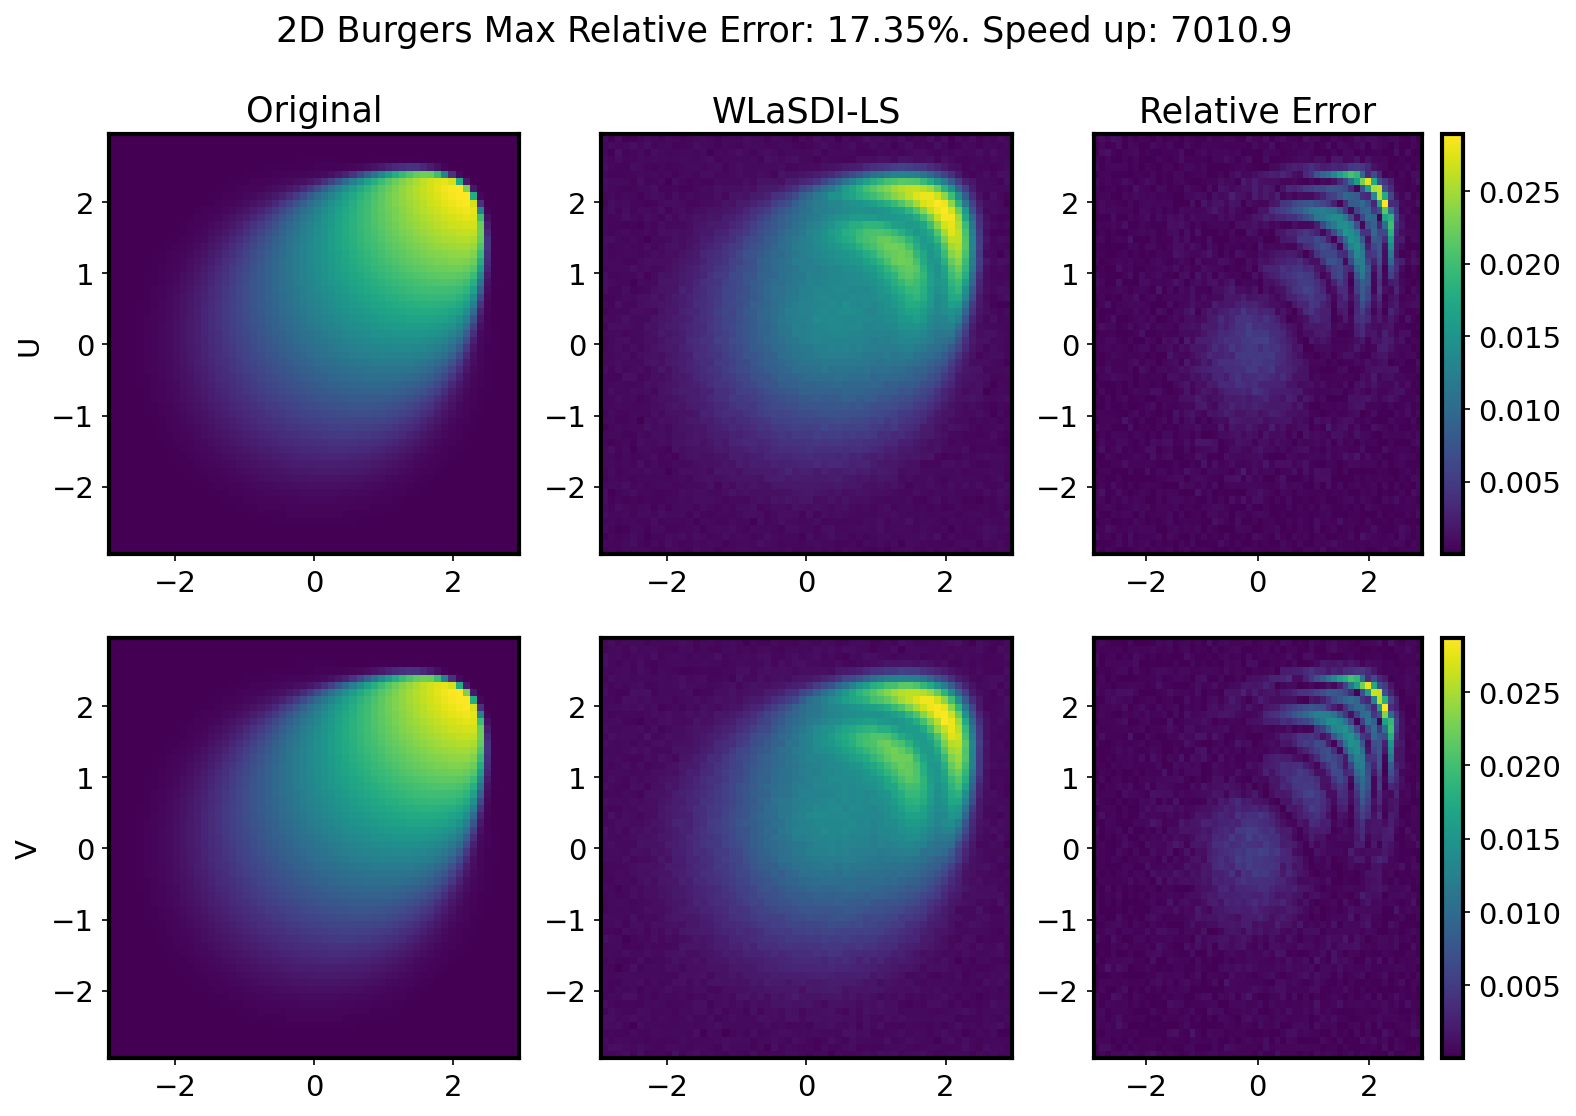

In [62]:
plt.rcParams['figure.dpi'] = 150 
plt.rcParams['font.size'] = 14
plt.rcParams['axes.linewidth'] = 2
fig = plt.figure()
ax1 = fig.add_subplot(2,3,1)
fig.set_size_inches(12,8)
z=plt.pcolormesh(x_free.reshape(nx-2,ny-2),y_free.reshape(nx-2,ny-2),u_full[k,free_raveled_indicies].reshape(nx-2,ny-2), shading = 'nearest')
fig.suptitle('2D Burgers Max Relative Error: {:.2f}%. Speed up: {:.1f}'.format(np.amax(max_re), speed_up))
ax1.set_title('Original')
ax1.set_ylabel('U')

ax2 = fig.add_subplot(2,3,2)
z=plt.pcolormesh(x_free.reshape(nx-2,ny-2),y_free.reshape(nx-2,ny-2),FOM_recon_u[k].reshape(nx-2,ny-2), shading = 'nearest')
ax2.set_title('WLaSDI-LS')

ax3 = fig.add_subplot(2,3,3)
z=plt.pcolormesh(x_free.reshape(nx-2,ny-2),y_free.reshape(nx-2,ny-2),np.abs(FOM_recon_u[k].reshape(nx-2,ny-2)-u_full[k,free_raveled_indicies].reshape(nx-2,ny-2))/LA.norm(v_full[k,free_raveled_indicies].reshape(nx-2,ny-2)), shading = 'nearest')
fig.colorbar(z, ax = ax3)
ax3.set_title('Relative Error')

ax4 = fig.add_subplot(2,3,4)
z=plt.pcolormesh(x_free.reshape(nx-2,ny-2),y_free.reshape(nx-2,ny-2),v_full[k,free_raveled_indicies].reshape(nx-2,ny-2), shading = 'nearest')
# fig.colorbar(z, ax = ax4)
ax4.set_ylabel('V')

ax5 = fig.add_subplot(2,3,5)
z=plt.pcolormesh(x_free.reshape(nx-2,ny-2),y_free.reshape(nx-2,ny-2),FOM_recon_v[k].reshape(nx-2,ny-2), shading = 'nearest')

ax6 = fig.add_subplot(2,3,6)
z=plt.pcolormesh(x_free.reshape(nx-2,ny-2),y_free.reshape(nx-2,ny-2),np.abs(FOM_recon_v[k].reshape(nx-2,ny-2)-v_full[k,free_raveled_indicies].reshape(nx-2,ny-2))/LA.norm(v_full[k,free_raveled_indicies].reshape(nx-2,ny-2)), shading = 'nearest')
fig.colorbar(z, ax = ax6)

Text(0, 0.5, 'Relative Error (%)')

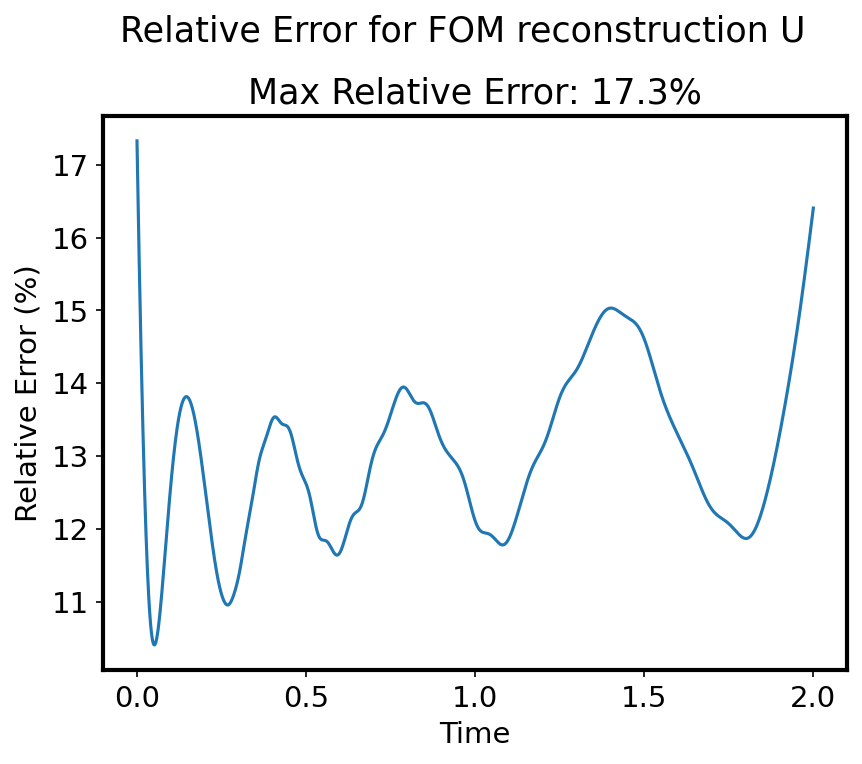

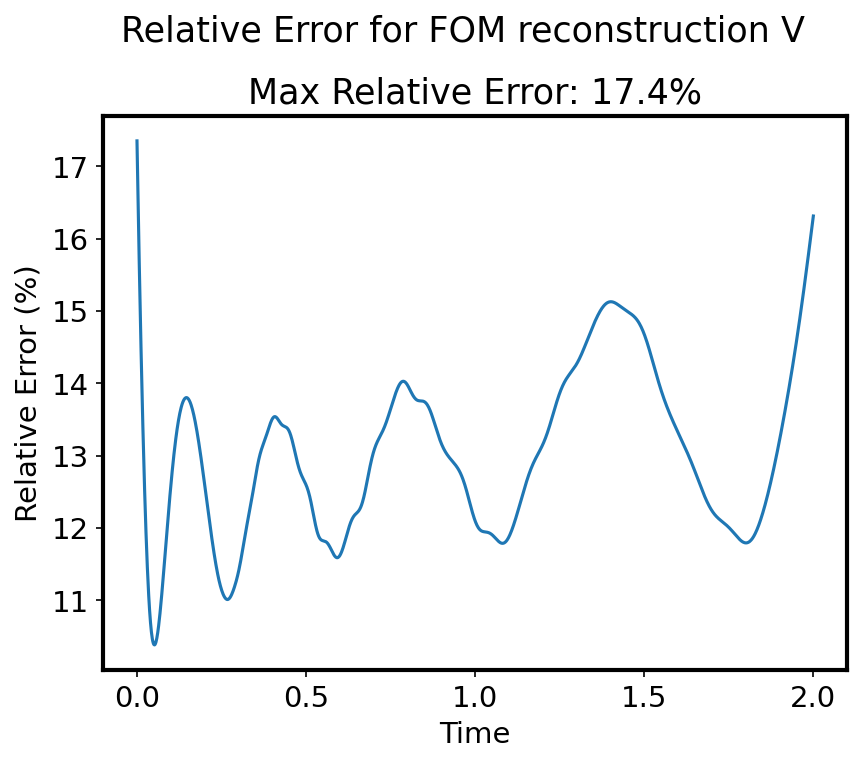

In [63]:
fig = plt.figure()
fig.suptitle('Relative Error for FOM reconstruction U', y = 1.02)
ax = plt.axes()
ax.set_title('Max Relative Error: {:.3}%'.format(np.amax(test_u)))
ax.plot(t, test_u)
ax.set_xlabel('Time')
ax.set_ylabel('Relative Error (%)')
fig = plt.figure()
fig.suptitle('Relative Error for FOM reconstruction V', y = 1.02)
ax = plt.axes()
ax.set_title('Max Relative Error: {:.3}%'.format(np.amax(test_v)))
ax.plot(t, test_v)
ax.set_xlabel('Time')
ax.set_ylabel('Relative Error (%)')